In [1]:
from gerrychain import Graph

In [2]:
# Read Oklahoma county graph from the json file "OK_county.json"
filepath = 'C:\\districting-data\\'
filename = 'OK_county.json'

# GerryChain has a built-in function for reading graphs of this type:
G = Graph.from_json( filepath + filename )

In [3]:
# Let's impose a 1% population deviation (+/- 0.5%)
deviation = 0.01

import math
k = 5          # number of districts
total_population = sum(G.nodes[node]['TOTPOP'] for node in G.nodes)

L = math.ceil((1-deviation/2)*total_population/k)
U = math.floor((1+deviation/2)*total_population/k)
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 746519 and U = 754021 and k = 5


In [4]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

# create variables
x = m.addVars(G.nodes, k, vtype=GRB.BINARY) # x[i,j] equals one when county i is assigned to district j
y = m.addVars(G.edges, vtype=GRB.BINARY)  # y[u,v] equals one when edge {u,v} is cut

Academic license - for non-commercial use only - expires 2021-04-22
Using license file C:\Users\buchanan\gurobi.lic


In [5]:
# objective is to minimize the total perimeter of the districts
#  the boundary length between counties u and v is stored in G.edges[u,v]['shared_perim']
m.setObjective( gp.quicksum( G.edges[u,v]['shared_perim']*y[u,v] for u,v in G.edges ), GRB.MINIMIZE )

In [6]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum(x[i,j] for j in range(k)) == 1 for i in G.nodes)

# add constraints saying that each district has population at least L and at most U
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U for j in range(k) )

# add constraints saying that edge {i,j} is cut if i is assigned to district v but j is not.
m.addConstrs( x[i,v] - x[j,v] <= y[i,j] for i,j in G.edges for v in range(k))

m.update()

In [7]:
# Now, let's add contiguity constraints and re-solve the model.
# We will use the contiguity constraints of Hojny et al. (MPC, 2021)
#   https://link.springer.com/article/10.1007/s12532-020-00186-3

# Add root variables: r[i,j] equals 1 if node i is the "root" of district j
r = m.addVars(G.nodes, k, vtype=GRB.BINARY)

# Add flow variables: f[u,v] = amount of flow sent across arc uv 
#  Flows are sent across arcs of the directed version of G which we call DG
import networkx as nx
DG = nx.DiGraph(G) # directed version of G
f = m.addVars(DG.edges, vtype=GRB.CONTINUOUS)

In [8]:
# The big-M proposed by Hojny et al.
M = G.number_of_nodes() - k + 1

# Each district j should have one root
m.addConstrs( gp.quicksum( r[i,j] for i in DG.nodes) == 1 for j in range(k) )

# If node i is not assigned to district j, then it cannot be its root
m.addConstrs( r[i,j] <= x[i,j] for i in DG.nodes for j in range(k) )  

# if not a root, consume some flow.
# if a root, only send out (so much) flow.
m.addConstrs( gp.quicksum( f[u,v] - f[v,u] for u in DG.neighbors(v) ) >= 1 - M * gp.quicksum( r[v,j] for j in range(k)) for v in G.nodes)

# do not send flow across cut edges
m.addConstrs( f[i,j] + f[j,i] <= M * (1 - y[i,j]) for (i,j) in G.edges )

m.update()

In [9]:
# solve IP model
m.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1724 rows, 1355 columns and 6985 nonzeros
Model fingerprint: 0x985dba51
Variable types: 390 continuous, 965 integer (965 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+05]
  Objective range  [9e-04, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+05]
Presolve time: 0.04s
Presolved: 1724 rows, 1355 columns, 6965 nonzeros
Variable types: 390 continuous, 965 integer (965 binary)

Root relaxation: objective 1.203141e+00, 758 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.50393    0  413          -    1.50393      -     -    0s
     0     0    1.75960    0  423          -    1.75960      -     -    0s
     0     0    3.51052    0  333          -    3.51052  

 228978 26848   12.73700   34  319   14.24922   11.39937  20.0%  93.9  391s
 229388 26881   13.63654   41  282   14.24922   11.40325  20.0%  93.9  397s
 229453 26955   12.84988   42  309   14.24922   11.40482  20.0%  93.9  400s
 230315 27358   12.54818   32  381   14.24922   11.41646  19.9%  94.0  405s
 231640 28070   13.64494   40  307   14.24922   11.43583  19.7%  94.1  410s
 234502 28983   13.81372   48  198   14.24922   11.46844  19.5%  94.2  416s
 236026 29494   14.07407   31  400   14.24922   11.48787  19.4%  94.4  421s
 237446 29716   13.82124   31  370   14.24922   11.49944  19.3%  94.5  426s
 238523 30352   13.86247   39  260   14.24922   11.51104  19.2%  94.6  431s
 240299 31031   12.33151   25  312   14.24922   11.52781  19.1%  94.8  435s
 242945 31886     cutoff   38        14.24922   11.55243  18.9%  94.9  442s
 244658 32467     cutoff   30        14.24922   11.56649  18.8%  95.0  446s
 246291 32943   12.17129   28  373   14.24922   11.57999  18.7%  95.1  452s
 247821 3349

 359811 62647     cutoff   37        14.24922   12.19698  14.4%  98.9  910s
 361571 63043   13.84354   34  300   14.24922   12.20459  14.3%  98.9  916s
 362434 63192   14.16458   44  258   14.24922   12.20667  14.3%  98.9  920s
 364042 63487     cutoff   45        14.24922   12.21348  14.3%  99.0  927s
 364566 63679   13.21604   27  416   14.24922   12.21585  14.3%  99.0  930s
 365422 63689     cutoff   37        14.24922   12.21831  14.3%  99.0  935s
 366472 64125   14.19036   45  271   14.24922   12.22214  14.2%  99.0  942s
 367403 64309     cutoff   40        14.24922   12.22554  14.2%  99.0  945s
 369129 64756     cutoff   38        14.24922   12.23107  14.2%  99.0  951s
 370797 65107   14.09026   32  403   14.24922   12.23604  14.1%  99.0  957s
 371571 65308   13.73870   42  191   14.24922   12.23788  14.1%  99.0  960s
 373188 65679   13.00571   29  334   14.24922   12.24341  14.1%  99.0  966s
 374926 66081   13.95301   28  315   14.24922   12.24918  14.0%  99.0  972s
 375746 6624

 601452 104354   13.38136   34  338   14.23463   12.75042  10.4%  96.7 1425s
 605074 104773     cutoff   37        14.23463   12.75667  10.4%  96.7 1431s
 608637 105284   14.10251   49  158   14.23463   12.76242  10.3%  96.6 1436s
 611242 105575   13.45975   41  140   14.23463   12.76666  10.3%  96.6 1440s
 614586 105998   14.05183   39  202   14.23463   12.77182  10.3%  96.5 1446s
 618214 106494   13.17047   37  340   14.23463   12.77733  10.2%  96.5 1451s
 620612 106776   13.35224   43  201   14.23463   12.78125  10.2%  96.4 1455s
 624175 107215     cutoff   33        14.23463   12.78685  10.2%  96.4 1460s
 627718 107674   13.40912   45  257   14.23463   12.79305  10.1%  96.3 1466s
 630121 107942     cutoff   31        14.23463   12.79650  10.1%  96.3 1470s
 633631 108407     cutoff   36        14.23463   12.80160  10.1%  96.2 1476s
 636390 108722   14.02622   50  170   14.23463   12.80597  10.0%  96.2 1480s
 639887 109152     cutoff   33        14.23463   12.81129  10.0%  96.1 1486s

 965322 128454     cutoff   50        14.23463   13.20669  7.22%  91.4 1960s
 969014 128478   13.71822   41  375   14.23463   13.21046  7.19%  91.4 1966s
 972006 128483   13.93087   42  242   14.23463   13.21358  7.17%  91.3 1970s
 975837 128474     cutoff   40        14.23463   13.21746  7.15%  91.3 1975s
 978623 128473     cutoff   44        14.23463   13.22040  7.13%  91.2 1980s
 981402 128395     cutoff   50        14.23463   13.22356  7.10%  91.2 1985s
 985028 128379   14.06719   32  356   14.23463   13.22694  7.08%  91.2 1990s
 987758 128373   14.05760   31  266   14.23463   13.22990  7.06%  91.1 1995s
 991624 128320   13.48805   38  230   14.23463   13.23403  7.03%  91.1 2000s
 995320 128251     cutoff   44        14.23463   13.23787  7.00%  91.0 2005s
 999159 128211   13.78687   36  313   14.23463   13.24148  6.98%  91.0 2010s
 1003709 128158     cutoff   42        14.23463   13.24607  6.94%  90.9 2016s
 1006516 128139     cutoff   44        14.23463   13.24871  6.93%  90.9 202

 1360630 89472   14.04698   41  229   14.23463   13.60042  4.46%  86.6 2486s
 1364981 88551   13.80120   53  156   14.23463   13.60526  4.42%  86.6 2490s
 1369229 87669     cutoff   54        14.23463   13.60981  4.39%  86.5 2496s
 1373284 86687   13.83030   36  314   14.23463   13.61464  4.36%  86.5 2500s
 1378790 85400   13.93804   38  258   14.23463   13.62059  4.31%  86.4 2506s
 1382698 84432   13.94138   44  154   14.23463   13.62535  4.28%  86.4 2510s
 1386814 83337     cutoff   36        14.23463   13.63060  4.24%  86.3 2515s
 1391156 82216   14.20802   41  278   14.23463   13.63573  4.21%  86.3 2520s
H1394606 81381                      14.2346263   13.63952  4.18%  86.2 2523s
 1395496 81278     cutoff   49        14.23463   13.64045  4.17%  86.2 2526s
 1399202 80073   14.02076   46  271   14.23463   13.64526  4.14%  86.2 2530s
 1403833 78789     cutoff   51        14.23463   13.65077  4.10%  86.1 2535s
H1407178 77999                      14.2346263   13.65482  4.07%  86.1 2538s

In [14]:
print("The total perimeter length (excluding the exterior boundary of state) is",m.objval)

# retrieve the districts and their populations
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [ [ G.nodes[i]["NAME10"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])

The total perimeter length (excluding the exterior boundary of state) is 14.234626457963815
District 0 has population 752140 and contains counties ['Payne', 'Caddo', 'Greer', 'Tillman', 'Harper', 'Grant', 'Dewey', 'Texas', 'Roger Mills', 'Kiowa', 'Beckham', 'Noble', 'Harmon', 'Major', 'Alfalfa', 'Beaver', 'Jackson', 'Cimarron', 'Ellis', 'Grady', 'Blaine', 'Woodward', 'Kingfisher', 'Comanche', 'Cotton', 'Custer', 'Garfield', 'Washita', 'Logan', 'Canadian', 'Woods']
District 1 has population 752906 and contains counties ['Oklahoma', 'Lincoln']
District 2 has population 750209 and contains counties ['Delaware', 'McIntosh', 'Le Flore', 'Nowata', 'Adair', 'Craig', 'Mayes', 'Muskogee', 'Ottawa', 'Pittsburg', 'Latimer', 'Creek', 'Sequoyah', 'Haskell', 'Cherokee', 'Wagoner', 'Okmulgee', 'Pawnee', 'Rogers']
District 3 has population 748413 and contains counties ['Tulsa', 'Kay', 'Washington', 'Osage']
District 4 has population 747683 and contains counties ['Marshall', 'Coal', 'Seminole', 'Murray

In [15]:
# Let's draw it on a map
import geopandas as gpd

In [16]:
# Read Oklahoma county shapefile from "OK_county.shp"
filepath = 'C:\\districting-data\\'
filename = 'OK_county.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filepath + filename )

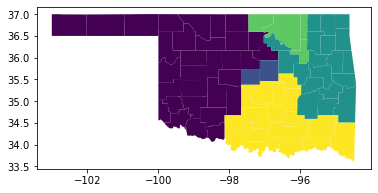

In [17]:
# Which district is each county assigned to?
assignment = [ -1 for u in G.nodes ]
    
# for each district j
for j in range(len(districts)):
    
    # for each node i in this district
    for i in districts[j]:
        
        # What is its GEOID?
        geoID = G.nodes[i]["GEOID10"]
        
        # Need to find this GEOID in the dataframe
        for u in G.nodes:
            if geoID == df['GEOID10'][u]: # Found it
                assignment[u] = j # Node u from the dataframe should be assigned to district j

# Now add the assignments to a column of the dataframe and map it
df['assignment'] = assignment
my_fig = df.plot(column='assignment').get_figure()